In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# 加载数据
data = pd.read_csv('./combined_data.csv')

# 删除不需要的列，例如时间戳或IP地址（假设你的数据集中有这些列）
data.drop([' Timestamp'], axis=1, inplace=True)

# 类型转换，将分类标签编码
label_encoder = LabelEncoder()
data[' Label'] = label_encoder.fit_transform(data[' Label'])

# 检查并处理无穷大和非常大的数值
data.replace([np.inf, -np.inf], np.nan, inplace=True)  # 将inf替换为NaN
data.fillna(data.median(), inplace=True)  # 使用中位数填充NaN，确保之前中位数计算不包括inf

# 特征标准化
scaler = StandardScaler()
X = scaler.fit_transform(data.drop(' Label', axis=1))  # 确保标签列不参与标准化
y = data[' Label']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("数据预处理完成，准备进行模型训练和测试。")


数据预处理完成，准备进行模型训练和测试。


In [2]:
import numpy as np

# 转换数据为torch张量
X_train_tensor = torch.tensor(X_train.astype(np.float32))  # 确保数据类型为 float32
y_train_tensor = torch.tensor(y_train.values.astype(np.int64))  # 先获取values再转换类型为 long (int64)
X_test_tensor = torch.tensor(X_test.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.int64))

# 创建数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 定义模型
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

# 初始化模型
input_size = X_train.shape[1]
num_classes = len(np.unique(y))
model = NeuralNetwork(input_size, num_classes)

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch [1/200], Loss: 0.6843, Train Acc: 62.38%, Test Acc: 59.50%
Epoch [2/200], Loss: 0.8461, Train Acc: 62.68%, Test Acc: 60.54%
Epoch [3/200], Loss: 0.8376, Train Acc: 62.18%, Test Acc: 60.46%
Epoch [4/200], Loss: 0.6336, Train Acc: 62.48%, Test Acc: 60.04%
Epoch [5/200], Loss: 0.8013, Train Acc: 62.38%, Test Acc: 60.92%
Epoch [6/200], Loss: 0.5960, Train Acc: 62.25%, Test Acc: 59.71%
Epoch [7/200], Loss: 0.9119, Train Acc: 63.48%, Test Acc: 59.42%
Epoch [8/200], Loss: 0.8993, Train Acc: 62.23%, Test Acc: 60.71%
Epoch [9/200], Loss: 0.6921, Train Acc: 63.23%, Test Acc: 59.71%
Epoch [10/200], Loss: 0.7252, Train Acc: 62.82%, Test Acc: 60.25%
Epoch [11/200], Loss: 0.8242, Train Acc: 62.88%, Test Acc: 60.33%
Epoch [12/200], Loss: 0.5485, Train Acc: 62.89%, Test Acc: 59.54%
Epoch [13/200], Loss: 0.7638, Train Acc: 63.52%, Test Acc: 60.83%
Epoch [14/200], Loss: 0.7582, Train Acc: 63.57%, Test Acc: 60.38%
Epoch [15/200], Loss: 0.8015, Train Acc: 62.30%, Test Acc: 59.50%
Epoch [16/200], Los

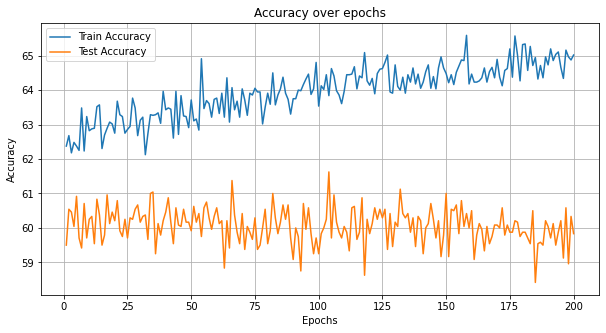

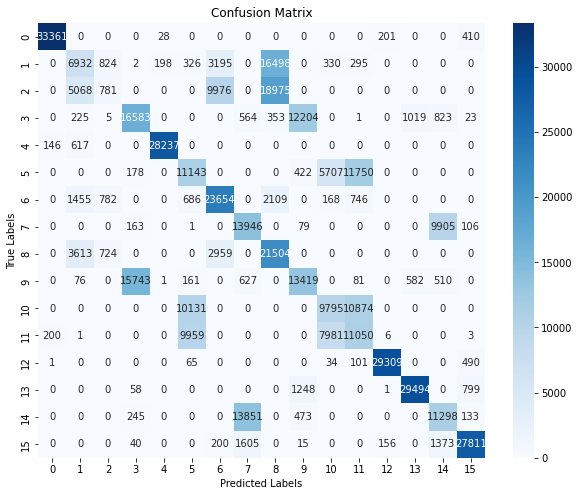

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np

num_epochs = 200
train_acc = []
test_acc = []
all_preds = []
all_labels = []

for epoch in range(num_epochs):
    model.train()  # 确保模型在训练模式
    correct_train = 0
    total_train = 0
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        _, predicted = torch.max(outputs.data, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 计算训练准确率
    train_accuracy = 100 * correct_train / total_train
    train_acc.append(train_accuracy)
    
    # 测试模型
    model.eval()  # 设置模型为评估模式
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64):
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    # 计算测试准确率
    test_accuracy = 100 * correct_test / total_test
    test_acc.append(test_accuracy)

    # 每个epoch打印训练和测试的损失和准确率
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')

# 绘制训练和测试准确率图
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_acc, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_acc, label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
